In [1]:
#For downloads
import gdown, os, gzip, shutil

# Basic data management and plotting
import pandas as pd
import numpy as np
from scipy import sparse
import matplotlib.pyplot as plt
import os

# Scanpy fundamentals
import anndata as ad
import scanpy as sc
import seaborn as sb

# sc.settings.set_figure_params(dpi=200, frameon=False)
sc.set_figure_params(figsize=(6, 6))
import scvi
from scvi.external import SOLO

/home/jupyter-mdiaz/.local/lib/python3.9/site-packages/scvi/_settings.py:63: UserWarning: Since v1.0.0, scvi-tools no longer uses a random seed by default. Run `scvi.settings.seed = 0` to reproduce results from previous versions.
  self.seed = seed
/home/jupyter-mdiaz/.local/lib/python3.9/site-packages/scvi/_settings.py:70: UserWarning: Setting `dl_pin_memory_gpu_training` is deprecated in v1.0 and will be removed in v1.1. Please pass in `pin_memory` to the data loaders instead.
  self.dl_pin_memory_gpu_training = (


# Integration & Batch effect remove

Single-cell experiments are often conducted in multiple batches or across different platforms, leading to technical variability. When combining datasets, these batch effects can introduce noise, making it challenging to identify true biological differences. Data integration aims to correct for these batch effects, allowing researchers to work with a unified, consistent dataset.

Data integration aligns multiple single-cell datasets, removing technical differences and allowing meaningful comparisons between them. This step is crucial when you want to analyze combined data, such as pooling samples from different experiments or merging data from different research groups which is the case of this analysis.

To remove these technical artifacts after integration, we employed **scVI (Single-cell Variational Inference)** which is a deep learning-based approach to data integration in single-cell analysis. It uses a variational autoencoder (VAE), a type of neural network, to create a low-dimensional representation of single-cell data. scVI's strength lies in its ability to model complex relationships in the data, making it particularly useful for integrating datasets with diverse batch structures or high heterogeneity.

### How it works

The model is trained on the combined dataset to learn its underlying structure, allowing it to map the high-dimensional data into a lower-dimensional "latent space." This latent space representation process key biological patterns while reducing technical noise, providing a common ground for integrating multiple datasets. During training, scVI identifies and corrects batch effects by distinguishing between biological and technical variability, ensuring that differences observed in the data reflect true biological variation. After integration, this latent space representation can be used for downstream analyses, including clustering, visualization with techniques like UMAP or t-SNE, and differential gene expression analysis. The integrated dataset from scVI offers a cohesive view of single-cell data, enabling meaningful insights into the biological complexity of the samples.

This process, after quality control and normalization were done, it took 5 to 6 hours for the scvi algorithm to completely integrate the 12 samples and correct the batch effect. 

In [2]:
%cd /datos/home/jupyter-mdiaz/scRNAseq_pipeline/adata_saved/

/datos/home/jupyter-mdiaz/scRNAseq_pipeline/adata_saved


In [3]:
adata = sc.read_h5ad('/datos/home/jupyter-mdiaz/scRNAseq_pipeline/adata_saved/P1_QC.h5ad')

In [4]:
adata

AnnData object with n_obs × n_vars = 1724 × 2000
    obs: 'n_genes', 'doublet', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden'
    var: 'gene_ids', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'hvg', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [5]:
def pp(h5ad_path):
    adata = sc.read_h5ad(h5ad_path) 
    sc.pp.filter_genes(adata, min_cells=10)
    sc.pp.highly_variable_genes(adata, n_top_genes=2000, subset=True, flavor='seurat_v3')
    scvi.model.SCVI.setup_anndata(adata)
    vae = scvi.model.SCVI(adata)
    vae.train()
    solo = SOLO.from_scvi_model(vae)
    solo.train()
    df = solo.predict()
    df['prediction'] = solo.predict(soft=False)
    df['dif'] = df.doublet - df.singlet
    doublets = df[(df.prediction == 'doublet') & (df.dif > 1)]
    df = df.dropna()
    adata = sc.read_h5ad(h5ad_path)
    adata.obs['Sample'] = h5ad_path.split('_')[2]  
    adata.obs['doublet'] = adata.obs.index.isin(doublets.index)
    adata = adata[~adata.obs.doublet]
    sc.pp.filter_cells(adata, min_genes=200)
    adata.var['mt'] = adata.var_names.str.startswith('mt-')
    sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
    upper_lim = np.quantile(adata.obs.n_genes_by_counts.values, .98)
    adata = adata[adata.obs.n_genes_by_counts < upper_lim]
    adata = adata[adata.obs.pct_counts_mt < 20]
    df = df.dropna()  
    return adata


In [6]:
os.listdir('/datos/home/jupyter-mdiaz/scRNAseq_pipeline/initial_h5ad')

['control7',
 'tumor3',
 'control3',
 'control4',
 'tumor4',
 'control6',
 'control1',
 'tumor1',
 'tumor5',
 'control5',
 'control2',
 'tumor2']

In [7]:
out = []
for file in os.listdir('/datos/home/jupyter-mdiaz/scRNAseq_pipeline/initial_h5ad/'):
    out.append(pp('/datos/home/jupyter-mdiaz/scRNAseq_pipeline/initial_h5ad/' + file))

/opt/tljh/user/lib/python3.9/abc.py:119: FutureWarning: SparseDataset is deprecated and will be removed in late 2024. It has been replaced by the public classes CSRDataset and CSCDataset.

For instance checks, use `isinstance(X, (anndata.experimental.CSRDataset, anndata.experimental.CSCDataset))` instead.

For creation, use `anndata.experimental.sparse_dataset(X)` instead.

  return _abc_instancecheck(cls, instance)
An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.
/home/jupyter-mdiaz/.local/lib/python3.9/site-packages/scvi/data/fields/_layer_field.py:101: UserWarning: Training will be faster when sparse matrix is formatted as CSR. It is safe to cast before model initialization.
  _verify_and_correct_data_format(adata, self.attr_name, self.attr_key)
/home/jupyter-mdiaz/.local/lib/python3.9/site-packages/torch/cuda/__init__.py:628: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/home/jupyter-mdiaz/

Epoch 1/400:   0%|          | 0/400 [00:00<?, ?it/s]

/opt/tljh/user/lib/python3.9/abc.py:119: FutureWarning: SparseDataset is deprecated and will be removed in late 2024. It has been replaced by the public classes CSRDataset and CSCDataset.

For instance checks, use `isinstance(X, (anndata.experimental.CSRDataset, anndata.experimental.CSCDataset))` instead.

For creation, use `anndata.experimental.sparse_dataset(X)` instead.

  return _abc_instancecheck(cls, instance)


Epoch 400/400: 100%|██████████| 400/400 [23:58<00:00,  3.08s/it, v_num=1, train_loss_step=1.28e+3, train_loss_epoch=1.14e+3]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [23:58<00:00,  3.60s/it, v_num=1, train_loss_step=1.28e+3, train_loss_epoch=1.14e+3]
INFO     Creating doublets, preparing SOLO model.                                                                  


/home/jupyter-mdiaz/.local/lib/python3.9/site-packages/scvi/data/fields/_layer_field.py:101: UserWarning: Training will be faster when sparse matrix is formatted as CSR. It is safe to cast before model initialization.
  _verify_and_correct_data_format(adata, self.attr_name, self.attr_key)
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 216/400:  54%|█████▍    | 216/400 [04:26<03:47,  1.24s/it, v_num=1, train_loss_step=0.213, train_loss_epoch=0.262] 
Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.254. Signaling Trainer to stop.


/home/jupyter-mdiaz/.local/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:159: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["n_genes"] = number
/home/jupyter-mdiaz/.local/lib/python3.9/site-packages/scvi/data/fields/_layer_field.py:101: UserWarning: Training will be faster when sparse matrix is formatted as CSR. It is safe to cast before model initialization.
  _verify_and_correct_data_format(adata, self.attr_name, self.attr_key)
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 400/400: 100%|██████████| 400/400 [34:24<00:00,  4.67s/it, v_num=1, train_loss_step=807, train_loss_epoch=802]    

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [34:24<00:00,  5.16s/it, v_num=1, train_loss_step=807, train_loss_epoch=802]
INFO     Creating doublets, preparing SOLO model.                                                                  


/home/jupyter-mdiaz/.local/lib/python3.9/site-packages/scvi/data/fields/_layer_field.py:101: UserWarning: Training will be faster when sparse matrix is formatted as CSR. It is safe to cast before model initialization.
  _verify_and_correct_data_format(adata, self.attr_name, self.attr_key)
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 230/400:  57%|█████▊    | 230/400 [06:25<04:44,  1.67s/it, v_num=1, train_loss_step=0.228, train_loss_epoch=0.277]
Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.278. Signaling Trainer to stop.


/home/jupyter-mdiaz/.local/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:159: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["n_genes"] = number
/opt/tljh/user/lib/python3.9/abc.py:119: FutureWarning: SparseDataset is deprecated and will be removed in late 2024. It has been replaced by the public classes CSRDataset and CSCDataset.

For instance checks, use `isinstance(X, (anndata.experimental.CSRDataset, anndata.experimental.CSCDataset))` instead.

For creation, use `anndata.experimental.sparse_dataset(X)` instead.

  return _abc_instancecheck(cls, instance)
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 400/400: 100%|██████████| 400/400 [04:49<00:00,  1.65it/s, v_num=1, train_loss_step=396, train_loss_epoch=354]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [04:49<00:00,  1.38it/s, v_num=1, train_loss_step=396, train_loss_epoch=354]
INFO     Creating doublets, preparing SOLO model.                                                                  


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 400/400: 100%|██████████| 400/400 [02:28<00:00,  2.39it/s, v_num=1, train_loss_step=0.541, train_loss_epoch=0.347]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [02:28<00:00,  2.69it/s, v_num=1, train_loss_step=0.541, train_loss_epoch=0.347]


/home/jupyter-mdiaz/.local/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:159: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["n_genes"] = number
/home/jupyter-mdiaz/.local/lib/python3.9/site-packages/anndata/_core/anndata.py:1908: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/jupyter-mdiaz/.local/lib/python3.9/site-packages/anndata/_core/anndata.py:1908: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 400/400: 100%|██████████| 400/400 [05:02<00:00,  1.56it/s, v_num=1, train_loss_step=367, train_loss_epoch=390]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [05:02<00:00,  1.32it/s, v_num=1, train_loss_step=367, train_loss_epoch=390]
INFO     Creating doublets, preparing SOLO model.                                                                  


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 400/400: 100%|██████████| 400/400 [02:42<00:00,  3.09it/s, v_num=1, train_loss_step=0.197, train_loss_epoch=0.269]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [02:42<00:00,  2.46it/s, v_num=1, train_loss_step=0.197, train_loss_epoch=0.269]


/home/jupyter-mdiaz/.local/lib/python3.9/site-packages/anndata/_core/anndata.py:1908: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/jupyter-mdiaz/.local/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:159: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["n_genes"] = number
/home/jupyter-mdiaz/.local/lib/python3.9/site-packages/anndata/_core/anndata.py:1908: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/jupyter-mdiaz/.local/lib/python3.9/site-packages/scvi/data/fields/_layer_field.py:101: UserWarning: Training will be faster when sparse matrix is formatted as CSR. It is safe to cast before model initialization.
  _verify_and_correct_data_format(adata, self.attr_name, self.attr_key)
GPU available: False, used: False
TPU available

Epoch 400/400: 100%|██████████| 400/400 [42:42<00:00,  3.12s/it, v_num=1, train_loss_step=979, train_loss_epoch=1.07e+3]      

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [42:42<00:00,  6.41s/it, v_num=1, train_loss_step=979, train_loss_epoch=1.07e+3]
INFO     Creating doublets, preparing SOLO model.                                                                  


/home/jupyter-mdiaz/.local/lib/python3.9/site-packages/scvi/data/fields/_layer_field.py:101: UserWarning: Training will be faster when sparse matrix is formatted as CSR. It is safe to cast before model initialization.
  _verify_and_correct_data_format(adata, self.attr_name, self.attr_key)
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 204/400:  51%|█████     | 204/400 [03:36<03:27,  1.06s/it, v_num=1, train_loss_step=0.202, train_loss_epoch=0.238]
Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.233. Signaling Trainer to stop.


/home/jupyter-mdiaz/.local/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:159: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["n_genes"] = number
/home/jupyter-mdiaz/.local/lib/python3.9/site-packages/scvi/data/fields/_layer_field.py:101: UserWarning: Training will be faster when sparse matrix is formatted as CSR. It is safe to cast before model initialization.
  _verify_and_correct_data_format(adata, self.attr_name, self.attr_key)
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 400/400: 100%|██████████| 400/400 [40:57<00:00,  3.53s/it, v_num=1, train_loss_step=577, train_loss_epoch=586]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [40:57<00:00,  6.14s/it, v_num=1, train_loss_step=577, train_loss_epoch=586]
INFO     Creating doublets, preparing SOLO model.                                                                  


/home/jupyter-mdiaz/.local/lib/python3.9/site-packages/scvi/data/fields/_layer_field.py:101: UserWarning: Training will be faster when sparse matrix is formatted as CSR. It is safe to cast before model initialization.
  _verify_and_correct_data_format(adata, self.attr_name, self.attr_key)
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 178/400:  44%|████▍     | 178/400 [11:15<14:02,  3.79s/it, v_num=1, train_loss_step=0.424, train_loss_epoch=0.345]
Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.353. Signaling Trainer to stop.


/home/jupyter-mdiaz/.local/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:159: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["n_genes"] = number
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 400/400: 100%|██████████| 400/400 [14:57<00:00, 10.52s/it, v_num=1, train_loss_step=349, train_loss_epoch=320]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [14:57<00:00,  2.24s/it, v_num=1, train_loss_step=349, train_loss_epoch=320]
INFO     Creating doublets, preparing SOLO model.                                                                  


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 342/400:  86%|████████▌ | 342/400 [07:19<01:14,  1.28s/it, v_num=1, train_loss_step=0.378, train_loss_epoch=0.282]
Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.269. Signaling Trainer to stop.


/home/jupyter-mdiaz/.local/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:159: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["n_genes"] = number
/home/jupyter-mdiaz/.local/lib/python3.9/site-packages/scvi/data/fields/_layer_field.py:101: UserWarning: Training will be faster when sparse matrix is formatted as CSR. It is safe to cast before model initialization.
  _verify_and_correct_data_format(adata, self.attr_name, self.attr_key)
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 400/400: 100%|██████████| 400/400 [19:46<00:00,  3.56s/it, v_num=1, train_loss_step=1.06e+3, train_loss_epoch=963]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [19:46<00:00,  2.97s/it, v_num=1, train_loss_step=1.06e+3, train_loss_epoch=963]
INFO     Creating doublets, preparing SOLO model.                                                                  


/home/jupyter-mdiaz/.local/lib/python3.9/site-packages/scvi/data/fields/_layer_field.py:101: UserWarning: Training will be faster when sparse matrix is formatted as CSR. It is safe to cast before model initialization.
  _verify_and_correct_data_format(adata, self.attr_name, self.attr_key)
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 147/400:  37%|███▋      | 147/400 [02:51<04:54,  1.17s/it, v_num=1, train_loss_step=0.143, train_loss_epoch=0.217]
Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.209. Signaling Trainer to stop.


/home/jupyter-mdiaz/.local/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:159: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["n_genes"] = number
/home/jupyter-mdiaz/.local/lib/python3.9/site-packages/scvi/data/fields/_layer_field.py:101: UserWarning: Training will be faster when sparse matrix is formatted as CSR. It is safe to cast before model initialization.
  _verify_and_correct_data_format(adata, self.attr_name, self.attr_key)
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 400/400: 100%|██████████| 400/400 [34:55<00:00,  5.14s/it, v_num=1, train_loss_step=860, train_loss_epoch=800] 

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [34:55<00:00,  5.24s/it, v_num=1, train_loss_step=860, train_loss_epoch=800]
INFO     Creating doublets, preparing SOLO model.                                                                  


/home/jupyter-mdiaz/.local/lib/python3.9/site-packages/scvi/data/fields/_layer_field.py:101: UserWarning: Training will be faster when sparse matrix is formatted as CSR. It is safe to cast before model initialization.
  _verify_and_correct_data_format(adata, self.attr_name, self.attr_key)
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 184/400:  46%|████▌     | 184/400 [05:30<06:27,  1.80s/it, v_num=1, train_loss_step=0.328, train_loss_epoch=0.279]
Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.276. Signaling Trainer to stop.


/home/jupyter-mdiaz/.local/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:159: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["n_genes"] = number
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 400/400: 100%|██████████| 400/400 [14:27<00:00,  2.26s/it, v_num=1, train_loss_step=240, train_loss_epoch=267]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [14:27<00:00,  2.17s/it, v_num=1, train_loss_step=240, train_loss_epoch=267]
INFO     Creating doublets, preparing SOLO model.                                                                  


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 243/400:  61%|██████    | 243/400 [04:43<03:03,  1.17s/it, v_num=1, train_loss_step=0.287, train_loss_epoch=0.238]
Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.214. Signaling Trainer to stop.


/home/jupyter-mdiaz/.local/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:159: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["n_genes"] = number
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 400/400: 100%|██████████| 400/400 [12:51<00:00,  1.96s/it, v_num=1, train_loss_step=366, train_loss_epoch=356]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [12:51<00:00,  1.93s/it, v_num=1, train_loss_step=366, train_loss_epoch=356]
INFO     Creating doublets, preparing SOLO model.                                                                  


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 287/400:  72%|███████▏  | 287/400 [04:31<01:46,  1.06it/s, v_num=1, train_loss_step=0.276, train_loss_epoch=0.343]
Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.327. Signaling Trainer to stop.


/home/jupyter-mdiaz/.local/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:159: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["n_genes"] = number
/home/jupyter-mdiaz/.local/lib/python3.9/site-packages/scvi/data/fields/_layer_field.py:101: UserWarning: Training will be faster when sparse matrix is formatted as CSR. It is safe to cast before model initialization.
  _verify_and_correct_data_format(adata, self.attr_name, self.attr_key)
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 400/400: 100%|██████████| 400/400 [1:05:24<00:00,  6.44s/it, v_num=1, train_loss_step=830, train_loss_epoch=770]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [1:05:24<00:00,  9.81s/it, v_num=1, train_loss_step=830, train_loss_epoch=770]
INFO     Creating doublets, preparing SOLO model.                                                                  


/home/jupyter-mdiaz/.local/lib/python3.9/site-packages/scvi/data/fields/_layer_field.py:101: UserWarning: Training will be faster when sparse matrix is formatted as CSR. It is safe to cast before model initialization.
  _verify_and_correct_data_format(adata, self.attr_name, self.attr_key)
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 237/400:  59%|█████▉    | 237/400 [08:08<05:36,  2.06s/it, v_num=1, train_loss_step=0.391, train_loss_epoch=0.295]
Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.275. Signaling Trainer to stop.


/home/jupyter-mdiaz/.local/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:159: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["n_genes"] = number


In [11]:
# Remove duplicate labels
for ad in out:
    ad.obs_names_make_unique()
    ad.var_names_make_unique()

# Concatenate Anndata object
adata = sc.concat(out)

# Make sure index and labels are unique
adata.obs_names_make_unique()
adata.var_names_make_unique()


/home/jupyter-mdiaz/.local/lib/python3.9/site-packages/anndata/_core/anndata.py:1908: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/jupyter-mdiaz/.local/lib/python3.9/site-packages/anndata/_core/anndata.py:1906: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/jupyter-mdiaz/.local/lib/python3.9/site-packages/anndata/utils.py:260: UserWarning: Suffix used (-[0-9]+) to deduplicate index values may make index values difficult to interpret. There values with a similar suffixes in the index. Consider using a different delimiter by passing `join={delimiter}`Example key collisions generated by the make_index_unique algorithm: ['GTCATTTCATTAGGCT-1']
  warnings.warn(


In [12]:
adata

AnnData object with n_obs × n_vars = 92578 × 11762
    obs: 'n_genes', 'Sample', 'doublet', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'

In [13]:
sc.pp.filter_genes(adata, min_cells = 10)

In [14]:
adata.X

<92578x11762 sparse matrix of type '<class 'numpy.float32'>'
	with 151609666 stored elements in Compressed Sparse Row format>

In [15]:
from scipy.sparse import csr_matrix

In [16]:
adata.X = csr_matrix(adata.X)
adata.X

<92578x11762 sparse matrix of type '<class 'numpy.float32'>'
	with 151609666 stored elements in Compressed Sparse Row format>

In [17]:
adata

AnnData object with n_obs × n_vars = 92578 × 11762
    obs: 'n_genes', 'Sample', 'doublet', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'n_cells'

In [18]:
adata.obs['Sample']


AAACCCAAGATAGTCA-1    h5ad/control7
AAACCCAAGGTAGACC-1    h5ad/control7
AAACCCACACGCACCA-1    h5ad/control7
AAACCCAGTTCTGACA-1    h5ad/control7
AAACCCATCCGCCTAT-1    h5ad/control7
                          ...      
TTTGTTGTCATTCATC-1      h5ad/tumor2
TTTGTTGTCCGTGGCA-1      h5ad/tumor2
TTTGTTGTCCTTGGAA-1      h5ad/tumor2
TTTGTTGTCGTCGCTT-1      h5ad/tumor2
TTTGTTGTCTAGGAAA-1      h5ad/tumor2
Name: Sample, Length: 92578, dtype: object

In [19]:
adata.write_h5ad('/datos/home/jupyter-mdiaz/scRNAseq_pipeline/adata_saved/P2_combined.h5ad')

In [20]:
#########################################

In [ ]:
adata = sc.read_h5ad('/datos/home/jupyter-mdiaz/scRNAseq_pipeline/adata_saved/P2_combined.h5ad')
adata

In [21]:
adata.obs.groupby('Sample').count()

/tmp/ipykernel_751646/2340059915.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  adata.obs.groupby('Sample').count()


,n_genes,doublet,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt
Sample,,,,,,
h5ad/control1,4533,4533,4533,4533,4533,4533
h5ad/control2,6475,6475,6475,6475,6475,6475
h5ad/control3,2332,2332,2332,2332,2332,2332
h5ad/control4,2776,2776,2776,2776,2776,2776
h5ad/control5,7359,7359,7359,7359,7359,7359
h5ad/control6,9167,9167,9167,9167,9167,9167
h5ad/control7,7462,7462,7462,7462,7462,7462
h5ad/tumor1,7130,7130,7130,7130,7130,7130
h5ad/tumor2,16258,16258,16258,16258,16258,16258


In [22]:
adata.obs["Sample"]

AAACCCAAGATAGTCA-1    h5ad/control7
AAACCCAAGGTAGACC-1    h5ad/control7
AAACCCACACGCACCA-1    h5ad/control7
AAACCCAGTTCTGACA-1    h5ad/control7
AAACCCATCCGCCTAT-1    h5ad/control7
                          ...      
TTTGTTGTCATTCATC-1      h5ad/tumor2
TTTGTTGTCCGTGGCA-1      h5ad/tumor2
TTTGTTGTCCTTGGAA-1      h5ad/tumor2
TTTGTTGTCGTCGCTT-1      h5ad/tumor2
TTTGTTGTCTAGGAAA-1      h5ad/tumor2
Name: Sample, Length: 92578, dtype: category
Categories (12, object): ['h5ad/control1', 'h5ad/control2', 'h5ad/control3', 'h5ad/control4', ..., 'h5ad/tumor2', 'h5ad/tumor3', 'h5ad/tumor4', 'h5ad/tumor5']

In [23]:
sc.pp.filter_genes(adata, min_cells = 100)

In [24]:
adata

AnnData object with n_obs × n_vars = 92578 × 11762
    obs: 'n_genes', 'Sample', 'doublet', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'n_cells'

In [25]:
adata.layers['counts'] = adata.X.copy()

In [26]:
sc.pp.normalize_total(adata, target_sum = 1e4)
sc.pp.log1p(adata)
adata.raw = adata

In [27]:
adata.obs.head()

,n_genes,Sample,doublet,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt
AAACCCAAGATAGTCA-1,2713,h5ad/control7,False,2713,6230.0,0.0,0.0
AAACCCAAGGTAGACC-1,3518,h5ad/control7,False,3518,9725.0,0.0,0.0
AAACCCACACGCACCA-1,3848,h5ad/control7,False,3848,12794.0,0.0,0.0
AAACCCAGTTCTGACA-1,2350,h5ad/control7,False,2350,4994.0,0.0,0.0
AAACCCATCCGCCTAT-1,4195,h5ad/control7,False,4195,15739.0,0.0,0.0


In [28]:
scvi.model.SCVI.setup_anndata(adata, layer = "counts",
                             categorical_covariate_keys=["Sample"],
                             continuous_covariate_keys=['pct_counts_mt', 'total_counts'])

In [29]:
model = scvi.model.SCVI(adata)

In [30]:
model.train() 

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 1/86:   0%|          | 0/86 [00:00<?, ?it/s]

/opt/tljh/user/lib/python3.9/abc.py:119: FutureWarning: SparseDataset is deprecated and will be removed in late 2024. It has been replaced by the public classes CSRDataset and CSCDataset.

For instance checks, use `isinstance(X, (anndata.experimental.CSRDataset, anndata.experimental.CSCDataset))` instead.

For creation, use `anndata.experimental.sparse_dataset(X)` instead.

  return _abc_instancecheck(cls, instance)


Epoch 86/86: 100%|██████████| 86/86 [36:18<00:00, 24.16s/it, v_num=1, train_loss_step=4.46e+3, train_loss_epoch=4.64e+3]

`Trainer.fit` stopped: `max_epochs=86` reached.


Epoch 86/86: 100%|██████████| 86/86 [36:18<00:00, 25.33s/it, v_num=1, train_loss_step=4.46e+3, train_loss_epoch=4.64e+3]


In [31]:
adata.obsm['X_scVI'] = model.get_latent_representation()

In [32]:
adata.layers['scvi_normalized'] = model.get_normalized_expression(library_size = 1e4)

In [33]:
sc.pp.neighbors(adata, use_rep = 'X_scVI')

In [34]:
sc.tl.umap(adata)
sc.tl.leiden(adata, resolution = 1)

We decided to use a resolution of 1 to separate as best we could and to facilitate subsequent cell identification. 

/home/jupyter-mdiaz/.local/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:401: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


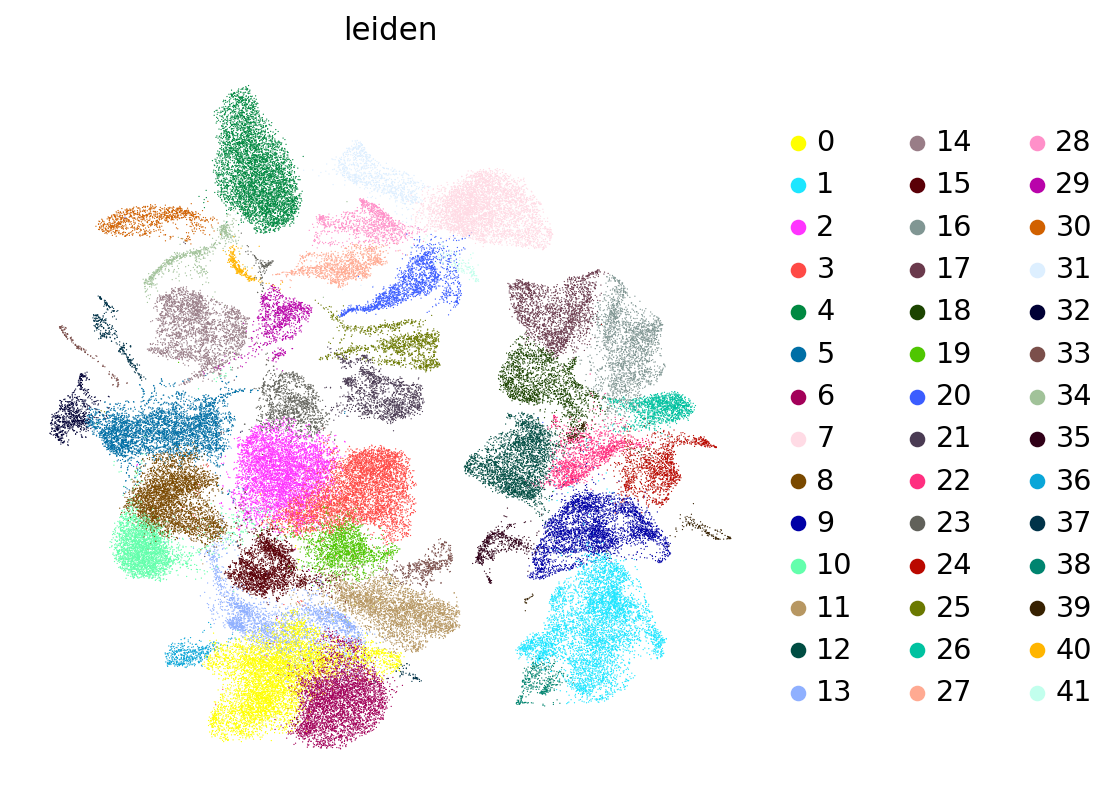

In [35]:
sc.pl.umap(adata, color = ['leiden'], frameon = False)

/home/jupyter-mdiaz/.local/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:401: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


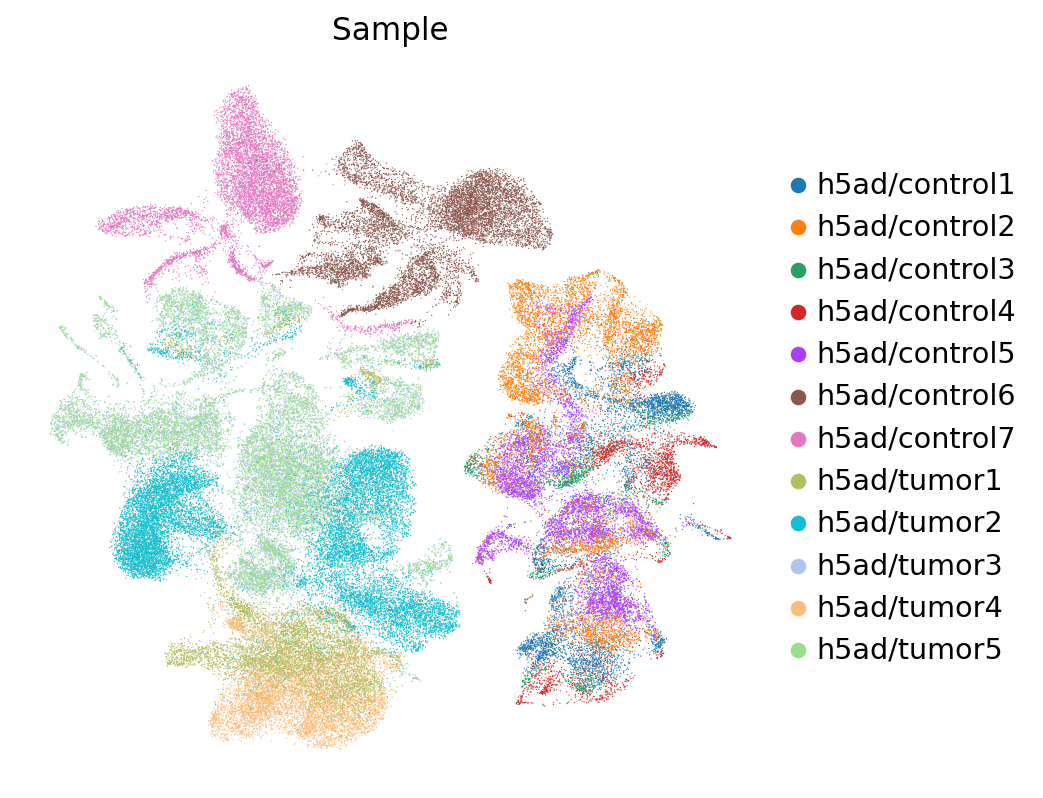

In [36]:
sc.pl.umap(adata, color = ['Sample'], frameon = False)

In [37]:
adata.write_h5ad('/datos/home/jupyter-mdiaz/scRNAseq_pipeline/adata_saved/P3_integrated.h5ad')

In [38]:
#Save scVI model
save_dir = '/datos/home/jupyter-mdiaz/scRNAseq_pipeline/adata_saved/'

model_dir = os.path.join(save_dir, "saved_model")

model.save(model_dir, save_anndata=True)